In [2]:
using SeisIO, Glob, Dates, PyPlot
import SeisIO: SeisIOBuf, checkbuf_8!, do_trace, checkbuf!,segy_ftypes,mktime,mk_t!,fastskip,NodalData,
segy_units, fillx_i16_be!, fastread, fast_readbytes!
import SeisIO.Nodal.read_nodal_segy

In [24]:
function fillx_i16_be_test!(x::AbstractArray, buf::Array{UInt8,1}, nx::Integer, os::Int64)
  y = zero(UInt32); j = os; i = 0
  while i < nx
    i += 1
    j += 1
    y  = UInt32(buf[2*i-1]) << 8
    y |= UInt32(buf[2*i])
    x[j] = signed(y)
  end
  return nothing
end
    
function read_nodal_segy_test(fname::String,
  nn::String,
  s::TimeSpec,
  t::TimeSpec,
  chans::SeisIO.ChanSpec,
  memmap::Bool,
  nx::Int=0)
    
  # define stuff
  BUF = SeisIOBuf()
  dtconst = 62135683200000000
    sμ = 1000000.0
    
  # Preprocessing
  # NEED TO UNDERSTAND WHY SHORTS IS BEING FILLED STRANGELY (AND WHAT IT ACTUALLY IS)
  (d0, d1) = parsetimewin(s, t)
  t0 = DateTime(d0).instant.periods.value*1000 - dtconst
  f = memmap ? IOBuffer(Mmap.mmap(fname)) : open(fname, "r")
  trace_fh = Array{Int32, 1}(undef, 3)
  shorts  = getfield(BUF, :int32_buf)
  fhd = Dict{String,Any}()
  # ww = Array{String, 1}(undef, 0)

  # ==========================================================================
  # Read file header
  fhd["filehdr"]  = fastread(f, 3200)
  fhd["jobid"]    = bswap(fastread(f, Int32))
  fhd["lineid"]   = bswap(fastread(f, Int32))
  fhd["reelid"]   = bswap(fastread(f, Int32))
  fast_readbytes!(f, BUF.buf, 48)
  fillx_i16_be_test!(shorts, BUF.buf, 24, 0)
  fastskip(f, 240)
  for i in 25:27
    shorts[i] = read(f, Int32)
  end
  fastskip(f, 94)
  if nx != 0
      shorts[5:6] .= nx
  end

  # check endianness; can be inconsistent; 0x0400 is a kludge
  # (stands for SEG Y rev 10.24, current is rev 2.0)
  # if (unsigned(shorts[25]) > 0x0400) || (shorts[26] < zero(Int16)) || (shorts[26] > one(Int16)) || (shorts[27] < zero(Int16))
  #   shorts[25:27] .= bswap.(shorts[25:27])
  #   push!(ww, "Inconsistent file header endianness")
  # end
  # fastskip(f, 94)

  # Process
  nh = max(zero(Int16), getindex(shorts, 27))
  fhd["exthdr"] = Array{String,1}(undef, nh)
  [fhd["exthdr"][i] = fastread(f, 3200) for i in 1:nh]
  for (j,i) in enumerate(String[ "ntr", "naux", "filedt", "origdt", "filenx",
                                 "orignx", "fmt", "cdpfold", "trasort", "vsum",
                                 "swst", "swen0", "swlen", "swtyp", "tapnum",
                                 "swtapst", "swtapen", "taptyp", "corrtra", "bgainrec",
                                 "amprec", "msys", "zupdn", "vibpol", "segyver",
                                 "isfixed", "n_exthdr" ])
    fhd[i] = shorts[j]
  end
  nt = getindex(shorts, 1)
  trace_fh[1] = getindex(shorts,3)
  trace_fh[2] = getindex(shorts,5)
  trace_fh[3] = getindex(shorts,7)
  # ==========================================================================
  # initialize NodalData container; set variables
  if isempty(chans)
    chans = 1:nt
  end
  fs = sμ / Float64(trace_fh[1])
  data = Array{Float32, 2}(undef, trace_fh[2], nt)
  S = NodalData(data, fhd, chans, t0)
  net = nn * "."
  cha = string("..O", getbandcode(fs), "0")

  # ==========================================================================
  # Read traces
  j = 0
  for i = 1:nt
    C = do_trace_test(f, false, true, 0x00, true, trace_fh)
    if i in chans
      j += 1
      S.id[j]       = string(net, lpad(i, 5, '0'), cha)
      S.name[j]     = string(C.misc["rec_no"], "_", i)
      S.fs[j]       = C.fs
      S.gain[j]     = C.gain
      S.misc[j]     = C.misc
      S.t[j]        = C.t
      S.data[:, j] .= C.x
    end
  end

  # TO DO: actually use s, t here

  # ==========================================================================
  # Cleanup
  close(f)
  resize!(BUF.buf, 65535)
  fill!(S.fs, fs)
  fill!(S.src, realpath(fname))
  fill!(S.units, "m/m")

  # Output warnings to STDOUT
  # if !isempty(ww)
  #   for i = 1:length(ww)
  #     @warn(ww[i])
  #   end
  # end
  # S.info["Warnings"] = ww
  return S
end

# THE FH THAT IS PASSED TO DO_TRACE MUST BE WRONG!
function do_trace_test(f::IO,
                  passcal::Bool,
                  full::Bool,
                  ll::UInt8,
                  swap::Bool,
                  fh::Array{Int32,1}
                  )

  # First part of trace header is quite standard
  sμ = 1000000.0
  BUF = SeisIOBuf()
  buf = BUF.buf
  ints = BUF.int32_buf
  shorts = BUF.int16_buf
  lat = 0.0
  lon = 0.0
  checkbuf_8!(buf, max(180, length(buf)))
  fast_readbytes!(f, buf, 180)

  intbuf = reinterpret(Int32, buf)
  copyto!(ints, 1, intbuf, 1, 7)
  copyto!(ints, 8, intbuf, 10, 8)
  copyto!(ints, 16, intbuf, 19, 4)

  shortbuf = reinterpret(Int16, buf)
  copyto!(shorts, 1, shortbuf, passcal ? 1 : 15, 4) # shorts[1:4]
  copyto!(shorts, 5, shortbuf, 35, 2)               # shorts[5:6]
  copyto!(shorts, 7, shortbuf, 45, 46)              # shorts[7:52]

  if passcal
    fast_readbytes!(f, buf, 40)

    scale_fac     = fastread(f, Float32)
    inst_no       = fastread(f, UInt16)
    shorts[62]    = fastread(f, Int16)
    ints[21]      = fastread(f, Int32)
    ints[22]      = fastread(f, Int32)
    ints[23]      = fastread(f, Int32)

    setindex!(shorts, shortbuf[10], 53)
    copyto!(shorts, 54, shortbuf, 13, 8)
    setindex!(ints, intbuf[6], 20)

    if swap
      shorts     .= ntoh.(shorts)
      ints       .= ntoh.(ints)
      scale_fac   = bswap(scale_fac)
      inst_no     = bswap(inst_no)
    end

    chars = buf[1:18]
    dt    = getindex(ints,20)
    n     = getindex(shorts, 20)
    fmt   = getindex(shorts, 54)
    nx    = (n == typemax(Int16) ? getindex(ints,21) : Int32(n))
    T     = (fmt == one(Int16) ? Int32 : Int16)
    nb    = checkbuf!(buf, nx, T)

    fast_readbytes!(f, buf, nb)

    # trace processing
    y = reinterpret(T, buf)
    x = Array{Float32,1}(undef, nx)
    if swap
      for i = 1:nx
        x[i] = bswap(y[i])
      end
    else
      copyto!(x, 1, y, 1, nx)
      # faster than reprocessing with fillx_ for long files
    end

    z = getindex(shorts, 5)
    δ = getindex(shorts, 21)
    fs        = sμ / Float64(δ == one(Int16) ? dt : δ)
    gain      = 1.0 / (Float64(scale_fac)  * 10.0^(-1.0*Float64(shorts[24]) / 10.0) / Float64(shorts[23]))
    lat, lon  = auto_coords(ints[18:19], shorts[6:7])
    if abs(lat) < 0.1 && abs(lon) < 0.1
      lat *= 3600.0
      lon *= 3600.0
    end
    el        = Float64(ints[9]) * Float64(abs(z))^(z < zero(Int16) ? -1.0 : 1.0)

    # Create ID
    id_arr = zeros(UInt8,8)
    i = one(Int8)
    o = one(Int8)
    while i < Int8(18)
      if chars[i] == 0x00
        chars[i] = 0x20
      end
      i = i+o
    end
    fill_id!(id_arr, chars, one(Int16), Int16(6), Int16(2), Int16(6))
    id_arr[1] = 0x2e
    id_arr[8] = 0x2e
    deleteat!(id_arr, id_arr.==0x00)

    # Channel string is tedious; use of one-char channel names like "Z"
    inds = Int64[]
    for i in 15:18
      if chars[i] > 0x20
        push!(inds, i)
      end
    end
    ch_arr = isempty(inds) ? UInt8[] : chars[inds]
    nc = length(ch_arr)
    if nc == 1
      c = uppercase(Char(ch_arr[1]))
      if c in ('Z','N','E')
        cha = string(getbandcode(fs), 'H', c)
      else
        cha = "YYY"
      end
    elseif nc == 0
      cha = "YYY"
    else
      cha = String(ch_arr[1:min(3, nc)])
    end
    id = String(id_arr) * cha

  else
    (dt, nx, fmt) = fh # THIS IS WHERE NX IS DEFINED
    fast_readbytes!(f, buf, 38)
    ints[26]      = fastread(f, Int32)
    shorts[60]    = fastread(f, Int16)
    ints[27]      = fastread(f, Int32)
    shorts[61]    = fastread(f, Int16)
    shorts[62]    = fastread(f, Int16)
    ints[28]      = fastread(f, Int32)
    ints[29]      = fastread(f, Int32)

    copyto!(ints, 20, intbuf, 1, 5)
    copyto!(shorts, 53, shortbuf, 11, 2)          # shorts[53:54]
    ints[25] = getindex(intbuf, 7)
    copyto!(shorts, 55, shortbuf, 15, 5)          # shorts[55:59]

    T = getindex(segy_ftypes, fmt)
    if (T == Any)
      close(f)
      error(string("Trace data code = ", fmt, "  unsupported!"))
    end
    nb = checkbuf!(buf, nx, T)
    fast_readbytes!(f, buf, nb)

    # trace processing
    x = Array{Float32,1}(undef, nx)
    if T == Int16
      fillx_i16_be!(x, buf, nx, 0)
    elseif T == Int32
      fillx_i32_be!(x, buf, nx, 0)
    elseif T == Int8
      fillx_i8!(x, buf, nx, 0)
    elseif T == Float32 # THIS IS WHERE OUR STUFF IS (NOT) HAPPENING. NX IS 0 AND BUF IS UINT8[]. WHY?
      x .= bswap.(reinterpret(Float16, buf))[1:nx]
    elseif T == UInt32
      y = Array{UInt32,1}(undef, nx)
      fillx_u32_le!(y, buf, nx, 0) # _le because ibmfloat bswaps
      x = ibmfloat.(y)
    end

    if swap
    shorts  .= ntoh.(shorts)
    ints    .= ntoh.(ints)
    end
    z       = getindex(shorts, 5)
    δ       = getindex(shorts, 21)
    fs      = sμ / Float64(δ)

    # not sure about meaning of "dB" in gain constants
    gain    = Float64(ints[25]) * 10.0^(shorts[55] + (shorts[23] + shorts[24])/10.0)
    el      = Float64(ints[9]) * Float64(abs(z))^(z<Int16(0) ? -1.0 : 1.0)

    # Create ID
    sta = string(reinterpret(UInt16, shorts[57]))
    lc = ll > 0x00 ? mk_lc(ints[ll]) : ""
    cha = Int16(10) < shorts[1] < Int16(18) ? trid(shorts[1]-Int16(10), fs, 1.0) : "YYY"
    id = string(".", sta[1:min(lastindex(sta),5)], ".", lc, ".", cha)

  end
  if full == true
    shorts_k = String["trace_id_code", "n_summed_z", "n_summed_h", "data_use",
      "z_sc", "h_sc", "h_units_code", "v_weather",
      "v_subweather", "t_src_uphole", "t_rec_uphole", "src_static_cor",
      "rec_static_cor", "total_static", "t_lag_a", "t_lag_b",
      "t_delay", "t_mute_st", "t_mute_en", "nx",
      "delta", "gain_type", "gain_const", "init_gain",
      "correlated", "sweep_st", "sweep_en", "sweep_len",
      "sweep_type", "sweep_tap_st", "sweep_tap_en", "tap_type",
      "f_alias", "slope_alias", "f_notch", "slope_notch",
      "f_low_cut", "f_high_cut", "slope_low_cut", "slope_high_cut",
      "year", "day", "hour", "minute",
      "second", "time_code", "trace_wt_fac", "geophone_roll_p1",
      "geophone_first_tr", "geophone_last_tr", "gap_size", "overtravel"]
    append!(shorts_k, passcal ?
        String["total_static_hi", "data_form", "ms", "trigyear",
        "trigday", "trighour", "trigminute", "trigsecond",
        "trigms", "not_to_be_used"] :
        String["shot_scalar", "trace_units_code", "trans_exp", "trans_units_code",
        "device_id", "trace_time_sc", "src_type_code", "src_energy_dir",
        "src_exp", "src_units_code"])

    ints_k = String["trace_seq_line", "trace_seq_file", "rec_no", "channel_no",
      "energy_src_pt", "ensemble_no", "trace_in_ensemble", "src-rec_dist",
      "rec_ele", "src_ele", "src_dep", "rec_datum_ele",
      "src_datum_ele", "src_water_dep", "rec_water_dep", "src_x",
      "src_y", "rec_x", "rec_y"]
    append!(ints_k, passcal ? String["samp_rate", "num_samps", "max", "min"] :
      String["cdp_x", "cdp_y", "inline_3d", "crossline_3d", "shot_point",
      "trans_mant", "unassigned_1", "unassigned_2"] )
    misc = Dict{String,Any}()
    [misc[shorts_k[i]] = shorts[i] for i in 1:length(shorts_k)]
    [misc[ints_k[i]] = ints[i] for i in 1:length(ints_k)]
    misc["scale_fac"] = gain
    if passcal
      sta = String(chars[1:6])
      misc["inst_no"] = inst_no
      misc["sensor_serial"] = String(chars[7:14])
    end
    misc["station_name"] = sta
    misc["channel_name"] = cha
  end

  # Trace info
  ts = mktime(shorts[41], shorts[42], shorts[43], shorts[45], shorts[45], zero(Int16)) +
        shorts[53] + 1000*sum(shorts[15:17])
  loc = GeoLoc()
  loc.lat = lat
  loc.lon = lon
  loc.el = el

  C = SeisChannel()
  setfield!(C, :name, id)
  setfield!(C, :id, id)
  setfield!(C, :loc, loc)
  setfield!(C, :gain, gain)
  setfield!(C, :fs, fs)
  mk_t!(C, length(x), ts)
  setfield!(C, :x, x)
  if passcal == false
    setfield!(C, :units, get(segy_units, Int16(shorts[56]), ""))
  end
  if full == true
    setfield!(C, :misc, misc)
  end
  return C
end

function read_nodal_test(fmt::String, fstr::String;
  chans   ::SeisIO.ChanSpec = Int64[]                   , # channels to proess
  memmap  ::Bool      = false                     , # use mmap? (DANGEROUS)
  nn      ::String    = "N0"                      , # network name
  s       ::TimeSpec  = "0001-01-01T00:00:00"     , # Start
  t       ::TimeSpec  = "9999-12-31T12:59:59"     , # End or Length (s)
  nx      ::Int = 0
    )

  #if fmt == "silixa"
  #  S = read_silixa_tdms(fstr, nn, s, t, chans, memmap, v)
  if fmt == "segy"
        if nx != 0
            S = read_nodal_segy_test(fstr, nn, s, t, chans, memmap, nx)
        else
            S = read_nodal_segy_test(fstr, nn, s, t, chans, memmap)
        end
  else
    error("Unrecognized format String!")
  end
  return S
end

read_nodal_test (generic function with 1 method)

In [25]:
function fillx_i16_be!(x::AbstractArray, buf::Array{UInt8,1}, nx::Integer, os::Int64)
  y = zero(UInt16); j = os; i = 0
  while i < nx
    i += 1
    j += 1
    y  = UInt16(buf[2*i-1]) << 8
    y |= UInt16(buf[2*i])
    x[j] = signed(y)
  end
  return nothing
end

function read_nodal_segy(fname::String,
  nn::String,
  s::TimeSpec,
  t::TimeSpec,
  chans::SeisIO.ChanSpec,
  memmap::Bool)

    
  # define stuff
  BUF = SeisIOBuf()
  dtconst = 62135683200000000
  sμ = 1000000.0
    
  # Preprocessing
  (d0, d1) = parsetimewin(s, t)
  t0 = DateTime(d0).instant.periods.value*1000 - dtconst
  f = memmap ? IOBuffer(Mmap.mmap(fname)) : open(fname, "r")
  trace_fh = Array{Int16, 1}(undef, 3)
  shorts  = getfield(BUF, :int16_buf)
  fhd = Dict{String,Any}()
  # ww = Array{String, 1}(undef, 0)

  # ==========================================================================
  # Read file header
  fhd["filehdr"]  = fastread(f, 3200)
  fhd["jobid"]    = bswap(fastread(f, Int32))
  fhd["lineid"]   = bswap(fastread(f, Int32))
  fhd["reelid"]   = bswap(fastread(f, Int32))
  fast_readbytes!(f, BUF.buf, 48)
  fillx_i16_be!(shorts, BUF.buf, 24, 0)
  fastskip(f, 240)
  for i in 25:27
    shorts[i] = read(f, Int16)
  end
  fastskip(f, 94)

  # check endianness; can be inconsistent; 0x0400 is a kludge
  # (stands for SEG Y rev 10.24, current is rev 2.0)
  # if (unsigned(shorts[25]) > 0x0400) || (shorts[26] < zero(Int16)) || (shorts[26] > one(Int16)) || (shorts[27] < zero(Int16))
  #   shorts[25:27] .= bswap.(shorts[25:27])
  #   push!(ww, "Inconsistent file header endianness")
  # end
  # fastskip(f, 94)

  # Process
  nh = max(zero(Int16), getindex(shorts, 27))
  fhd["exthdr"] = Array{String,1}(undef, nh)
  [fhd["exthdr"][i] = fastread(f, 3200) for i in 1:nh]
  for (j,i) in enumerate(String[ "ntr", "naux", "filedt", "origdt", "filenx",
                                 "orignx", "fmt", "cdpfold", "trasort", "vsum",
                                 "swst", "swen0", "swlen", "swtyp", "tapnum",
                                 "swtapst", "swtapen", "taptyp", "corrtra", "bgainrec",
                                 "amprec", "msys", "zupdn", "vibpol", "segyver",
                                 "isfixed", "n_exthdr" ])
    fhd[i] = shorts[j]
  end

  nt = getindex(shorts, 1)
  trace_fh[1] = getindex(shorts,3)
  trace_fh[2] = getindex(shorts,5)
  trace_fh[3] = getindex(shorts,7)

  # ==========================================================================
  # initialize NodalData container; set variables
  if isempty(chans)
    chans = 1:nt
  end
  fs = sμ / Float64(trace_fh[1])
  data = Array{Float32, 2}(undef, trace_fh[2], nt)
  S = NodalData(data, fhd, chans, t0)
  net = nn * "."
  cha = string("..O", getbandcode(fs), "0")

  # ==========================================================================
  # Read traces
  j = 0
  print(trace_fh)
  for i = 1:nt
    C = do_trace(f, false, true, 0x00, true, trace_fh)
    if i in chans
      j += 1
      S.id[j]       = string(net, lpad(i, 5, '0'), cha)
      S.name[j]     = string(C.misc["rec_no"], "_", i)
      S.fs[j]       = C.fs
      S.gain[j]     = C.gain
      S.misc[j]     = C.misc
      S.t[j]        = C.t
      S.data[:, j] .= C.x
    end
  end

  # TO DO: actually use s, t here

  # ==========================================================================
  # Cleanup
  close(f)
  resize!(BUF.buf, 65535)
  fill!(S.fs, fs)
  fill!(S.src, realpath(fname))
  fill!(S.units, "m/m")

  # Output warnings to STDOUT
  # if !isempty(ww)
  #   for i = 1:length(ww)
  #     @warn(ww[i])
  #   end
  # end
  # S.info["Warnings"] = ww
  return S
end

function do_trace(f::IO,
                  passcal::Bool,
                  full::Bool,
                  ll::UInt8,
                  swap::Bool,
                  fh::Array{Int16,1}
                  )

  # First part of trace header is quite standard
  sμ = 1000000.0
  BUF = SeisIOBuf()
  buf = BUF.buf
  ints = BUF.int32_buf
  shorts = BUF.int16_buf
  lat = 0.0
  lon = 0.0
  checkbuf_8!(buf, max(180, length(buf)))
  fast_readbytes!(f, buf, 180)

  intbuf = reinterpret(Int32, buf)
  copyto!(ints, 1, intbuf, 1, 7)
  copyto!(ints, 8, intbuf, 10, 8)
  copyto!(ints, 16, intbuf, 19, 4)

  shortbuf = reinterpret(Int16, buf)
  copyto!(shorts, 1, shortbuf, passcal ? 1 : 15, 4) # shorts[1:4]
  copyto!(shorts, 5, shortbuf, 35, 2)               # shorts[5:6]
  copyto!(shorts, 7, shortbuf, 45, 46)              # shorts[7:52]

  if passcal
    fast_readbytes!(f, buf, 40)

    scale_fac     = fastread(f, Float32)
    inst_no       = fastread(f, UInt16)
    shorts[62]    = fastread(f, Int16)
    ints[21]      = fastread(f, Int32)
    ints[22]      = fastread(f, Int32)
    ints[23]      = fastread(f, Int32)

    setindex!(shorts, shortbuf[10], 53)
    copyto!(shorts, 54, shortbuf, 13, 8)
    setindex!(ints, intbuf[6], 20)

    if swap
      shorts     .= ntoh.(shorts)
      ints       .= ntoh.(ints)
      scale_fac   = bswap(scale_fac)
      inst_no     = bswap(inst_no)
    end

    chars = buf[1:18]
    dt    = getindex(ints,20)
    n     = getindex(shorts, 20)
    fmt   = getindex(shorts, 54)
    nx    = (n == typemax(Int16) ? getindex(ints,21) : Int32(n))
    T     = (fmt == one(Int16) ? Int32 : Int16)
    nb    = checkbuf!(buf, nx, T)

    fast_readbytes!(f, buf, nb)

    # trace processing
    y = reinterpret(T, buf)
    x = Array{Float32,1}(undef, nx)
    if swap
      for i = 1:nx
        x[i] = bswap(y[i])
      end
    else
      copyto!(x, 1, y, 1, nx)
      # faster than reprocessing with fillx_ for long files
    end

    z = getindex(shorts, 5)
    δ = getindex(shorts, 21)
    fs        = sμ / Float64(δ == one(Int16) ? dt : δ)
    gain      = 1.0 / (Float64(scale_fac)  * 10.0^(-1.0*Float64(shorts[24]) / 10.0) / Float64(shorts[23]))
    lat, lon  = auto_coords(ints[18:19], shorts[6:7])
    if abs(lat) < 0.1 && abs(lon) < 0.1
      lat *= 3600.0
      lon *= 3600.0
    end
    el        = Float64(ints[9]) * Float64(abs(z))^(z < zero(Int16) ? -1.0 : 1.0)

    # Create ID
    id_arr = zeros(UInt8,8)
    i = one(Int8)
    o = one(Int8)
    while i < Int8(18)
      if chars[i] == 0x00
        chars[i] = 0x20
      end
      i = i+o
    end
    fill_id!(id_arr, chars, one(Int16), Int16(6), Int16(2), Int16(6))
    id_arr[1] = 0x2e
    id_arr[8] = 0x2e
    deleteat!(id_arr, id_arr.==0x00)

    # Channel string is tedious; use of one-char channel names like "Z"
    inds = Int64[]
    for i in 15:18
      if chars[i] > 0x20
        push!(inds, i)
      end
    end
    ch_arr = isempty(inds) ? UInt8[] : chars[inds]
    nc = length(ch_arr)
    if nc == 1
      c = uppercase(Char(ch_arr[1]))
      if c in ('Z','N','E')
        cha = string(getbandcode(fs), 'H', c)
      else
        cha = "YYY"
      end
    elseif nc == 0
      cha = "YYY"
    else
      cha = String(ch_arr[1:min(3, nc)])
    end
    id = String(id_arr) * cha

  else
    (dt, nx, fmt) = fh
    fast_readbytes!(f, buf, 38)
    ints[26]      = fastread(f, Int32)
    shorts[60]    = fastread(f, Int16)
    ints[27]      = fastread(f, Int32)
    shorts[61]    = fastread(f, Int16)
    shorts[62]    = fastread(f, Int16)
    ints[28]      = fastread(f, Int32)
    ints[29]      = fastread(f, Int32)

    copyto!(ints, 20, intbuf, 1, 5)
    copyto!(shorts, 53, shortbuf, 11, 2)          # shorts[53:54]
    ints[25] = getindex(intbuf, 7)
    copyto!(shorts, 55, shortbuf, 15, 5)          # shorts[55:59]

    T = getindex(segy_ftypes, fmt)
    if (T == Any)
      close(f)
      error(string("Trace data code = ", fmt, "  unsupported!"))
    end
    nb = checkbuf!(buf, nx, T)
    fast_readbytes!(f, buf, nb)

    # trace processing
    x = Array{Float32,1}(undef, nx)
    if T == Int16
      fillx_i16_be!(x, buf, nx, 0)
    elseif T == Int32
      fillx_i32_be!(x, buf, nx, 0)
    elseif T == Int8
      fillx_i8!(x, buf, nx, 0)
    elseif T == Float32
      x .= bswap.(reinterpret(Float32, buf))[1:nx]
    elseif T == UInt32
      y = Array{UInt32,1}(undef, nx)
      fillx_u32_le!(y, buf, nx, 0) # _le because ibmfloat bswaps
      x = ibmfloat.(y)
    end

    if swap
    shorts  .= ntoh.(shorts)
    ints    .= ntoh.(ints)
    end
    z       = getindex(shorts, 5)
    δ       = getindex(shorts, 21)
    fs      = sμ / Float64(δ)

    # not sure about meaning of "dB" in gain constants
    gain    = Float64(ints[25]) * 10.0^(shorts[55] + (shorts[23] + shorts[24])/10.0)
    el      = Float64(ints[9]) * Float64(abs(z))^(z<Int16(0) ? -1.0 : 1.0)

    # Create ID
    sta = string(reinterpret(UInt16, shorts[57]))
    lc = ll > 0x00 ? mk_lc(ints[ll]) : ""
    cha = Int16(10) < shorts[1] < Int16(18) ? trid(shorts[1]-Int16(10), fs, 1.0) : "YYY"
    id = string(".", sta[1:min(lastindex(sta),5)], ".", lc, ".", cha)

  end
  if full == true
    shorts_k = String["trace_id_code", "n_summed_z", "n_summed_h", "data_use",
      "z_sc", "h_sc", "h_units_code", "v_weather",
      "v_subweather", "t_src_uphole", "t_rec_uphole", "src_static_cor",
      "rec_static_cor", "total_static", "t_lag_a", "t_lag_b",
      "t_delay", "t_mute_st", "t_mute_en", "nx",
      "delta", "gain_type", "gain_const", "init_gain",
      "correlated", "sweep_st", "sweep_en", "sweep_len",
      "sweep_type", "sweep_tap_st", "sweep_tap_en", "tap_type",
      "f_alias", "slope_alias", "f_notch", "slope_notch",
      "f_low_cut", "f_high_cut", "slope_low_cut", "slope_high_cut",
      "year", "day", "hour", "minute",
      "second", "time_code", "trace_wt_fac", "geophone_roll_p1",
      "geophone_first_tr", "geophone_last_tr", "gap_size", "overtravel"]
    append!(shorts_k, passcal ?
        String["total_static_hi", "data_form", "ms", "trigyear",
        "trigday", "trighour", "trigminute", "trigsecond",
        "trigms", "not_to_be_used"] :
        String["shot_scalar", "trace_units_code", "trans_exp", "trans_units_code",
        "device_id", "trace_time_sc", "src_type_code", "src_energy_dir",
        "src_exp", "src_units_code"])

    ints_k = String["trace_seq_line", "trace_seq_file", "rec_no", "channel_no",
      "energy_src_pt", "ensemble_no", "trace_in_ensemble", "src-rec_dist",
      "rec_ele", "src_ele", "src_dep", "rec_datum_ele",
      "src_datum_ele", "src_water_dep", "rec_water_dep", "src_x",
      "src_y", "rec_x", "rec_y"]
    append!(ints_k, passcal ? String["samp_rate", "num_samps", "max", "min"] :
      String["cdp_x", "cdp_y", "inline_3d", "crossline_3d", "shot_point",
      "trans_mant", "unassigned_1", "unassigned_2"] )
    misc = Dict{String,Any}()
    [misc[shorts_k[i]] = shorts[i] for i in 1:length(shorts_k)]
    [misc[ints_k[i]] = ints[i] for i in 1:length(ints_k)]
    misc["scale_fac"] = gain
    if passcal
      sta = String(chars[1:6])
      misc["inst_no"] = inst_no
      misc["sensor_serial"] = String(chars[7:14])
    end
    misc["station_name"] = sta
    misc["channel_name"] = cha
  end

  # Trace info
  ts = mktime(shorts[41], shorts[42], shorts[43], shorts[45], shorts[45], zero(Int16)) +
        shorts[53] + 1000*sum(shorts[15:17])
  loc = GeoLoc()
  loc.lat = lat
  loc.lon = lon
  loc.el = el

  C = SeisChannel()
  setfield!(C, :name, id)
  setfield!(C, :id, id)
  setfield!(C, :loc, loc)
  setfield!(C, :gain, gain)
  setfield!(C, :fs, fs)
  mk_t!(C, length(x), ts)
  setfield!(C, :x, x)
  if passcal == false
    setfield!(C, :units, get(segy_units, Int16(shorts[56]), ""))
  end
  if full == true
    setfield!(C, :misc, misc)
  end
  return C
end

function read_nodal(fmt::String, fstr::String;
  chans   ::SeisIO.ChanSpec = Int64[]                   , # channels to proess
  memmap  ::Bool      = false                     , # use mmap? (DANGEROUS)
  nn      ::String    = "N0"                      , # network name
  s       ::TimeSpec  = "0001-01-01T00:00:00"     , # Start
  t       ::TimeSpec  = "9999-12-31T12:59:59"     , # End or Length (s)
  #v       ::Integer   = KW.v                      , # verbosity
  )

  #if fmt == "silixa"
  #  S = read_silixa_tdms(fstr, nn, s, t, chans, memmap, v)
  if fmt == "segy"
    S = read_nodal_segy(fstr, nn, s, t, chans, memmap)
  else
    error("Unrecognized format String!")
  end
  return S
end

read_nodal (generic function with 1 method)

Int16[1000, 30000, 5]

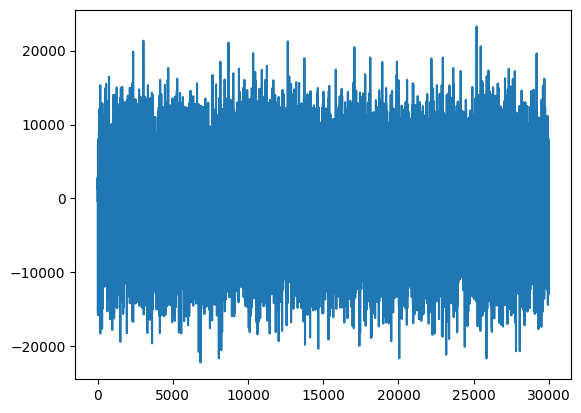

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4cd67187b8>

In [31]:
# list all the Greenland files
path = "/1-fnp/petasaur/p-wd03/greenland/Store Glacier DAS data/"
files_1khz = glob("1kHz/*",path)
files_4khz = glob("4kHz/*",path)
N = read_nodal("segy",files_1khz[2])
PyPlot.plot(N.data[:,1])

In [34]:
N2

NodalData with 2688 channels (2 shown)
COORDS: X = 0.0, Y = 0.0, Z = 0.0
  INFO: 32 entries
    ID: N0.00001..OG0                      N0.00002..OG0                      …
  NAME: 65536_1                            131072_2                           …
   LOC: x 0.0, y 0.0, z 0.0                x 0.0, y 0.0, z 0.0                …
    FS: 1000.0                             1000.0                             …
  GAIN: -65536.0                           -65536.0                           …
  RESP: a0 1.0, f0 1.0, 1z, 1p             a0 1.0, f0 1.0, 1z, 1p             …
 UNITS: m/m                                m/m                                …
   SRC: /auto/petasaur-wd03/greenland/Sto… /auto/petasaur-wd03/greenland/Sto… …
  MISC: 92 entries                         92 entries                         …
 NOTES: 0 entries                          0 entries                          …
     T: 0012-01-20T04:00:30 (0 gaps)       0012-01-20T04:00:30 (0 gaps)       …
     X: -5.469e+00          

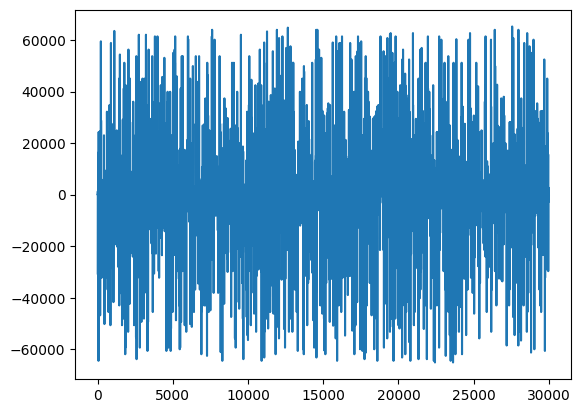

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4cd6143d30>

In [32]:
# list all the Greenland files
path = "/1-fnp/petasaur/p-wd03/greenland/Store Glacier DAS data/"
files_1khz = glob("1kHz/*",path)
files_4khz = glob("4kHz/*",path)
N2 = read_nodal_test("segy",files_1khz[2])
PyPlot.plot(N2.data[:,1])

In [ ]:
# current debug summary
# nx is set to 0 before trace processing block at 259! it's (correctly) 30000 for the 1khz files.
# buf is also empty there.
# nx and others are defined using fh at line 233. It's right for 1khz and wrong for 4khz.
# shorts contains lots of file metadata, but because it's int16, it cannot store proper metadata for files with 
# number of samples greater than 37000(ish)

# CURRENT SOLUTION: READ WITH OBSPY, DOWNSAMPLE TO 1KHZ, THEN TRY WITH SEISIO WORKFLOW